In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt

from torchvision import datasets, transforms

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

mnist_mean = (0.1307,)
mnist_std = (0.3081,)


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

## Dataloaders
train_dataset = datasets.MNIST('mnist_data/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist_data/', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view((-1, 28 * 28))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net().to(device)
model.train()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [2]:
def fgsm(model, x, y, eps):
    model.eval()
    x = x.clone().detach().to(device)
    x.requires_grad = True

    output = model(x)
    loss = criterion(output, y)

    model.zero_grad()
    loss.backward()

    gradient = x.grad.data
    sign_gradient = torch.sign(gradient)

    adv = x + eps * sign_gradient
    adv = torch.clamp(adv, 0, 1)

    return adv

def pgd(model, x, y, k, eps, eps_step):
    model.eval()

    tempt = x.clone().detach().to(device)
    tempt.requires_grad = True

    for _ in range(k):
        tempt = fgsm(model, tempt, y, eps_step)
        tempt = torch.clamp(tempt, x - eps, x + eps)
        tempt = torch.clamp(tempt, 0, 1)

    return tempt

In [3]:
def bounds_calculation(model, data, epsilon):
    model.eval()
    lower_bound = data - epsilon
    upper_bound = data + epsilon

    # print(model.modules())
    layers = list(model.children())

    for layer in layers:
        # print(layer)
        if isinstance(layer, nn.ReLU):
            lower_bound = torch.clamp(lower_bound, min=0)
            upper_bound = torch.clamp(upper_bound, min=0)
            # https://github.com/google-deepmind/interval-bound-propagation/blob/217a14d12686e08ebb5cfea1f2748cce58a55913/interval_bound_propagation/src/crown.py


        elif isinstance(layer, nn.Linear):
            lower_bound = lower_bound.view(lower_bound.size(0), -1)
            upper_bound = upper_bound.view(upper_bound.size(0), -1)

            # print(layer.weight)

            positive = torch.clamp(layer.weight, min=0)
            negative = torch.clamp(layer.weight, max=0)

            lower = torch.matmul(lower_bound, positive.T) + torch.matmul(upper_bound, negative.T)
            upper = torch.matmul(upper_bound, positive.T) + torch.matmul(lower_bound, negative.T)

            lower_bound = lower + layer.bias
            upper_bound = upper + layer.bias

    return lower_bound, upper_bound

In [4]:
def ibp_loss(normal_output, target, lower_bound, upper_bound, k):
    # https://github.com/google-deepmind/interval-bound-propagation/blob/217a14d12686e08ebb5cfea1f2748cce58a55913/interval_bound_propagation/src/loss.py
    normal_loss = criterion(normal_output, target)

    worst = lower_bound.clone()
    indexs = (torch.arange(target.size(0)), target)
    worst[indexs] = upper_bound[indexs]

    robust_loss = criterion(worst, target)

    return k * normal_loss + (1 - k) * robust_loss
    # return (1 - k) * normal_loss + k * robust_loss

In [5]:
def train(model, train_loader, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        k = 1 - 0.5 * (epoch / epochs)
        e_train = 0.1 * (epoch / epochs)
        for batch_index, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)

            lower_bound, upper_bound = bounds_calculation(model, data, e_train)

            loss = ibp_loss(output, target, lower_bound, upper_bound, k)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()


def test(model, test_loader, epsilon, attack=True):
    model.eval()
    correct = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        if epsilon > 0:
            if attack:
                data = pgd(model, data, target, k=10, eps=epsilon, eps_step=epsilon / 4)

        output = model(data)
        prediction = output.argmax(dim=1)

        correct += (target == prediction).sum().item()
    
    accuracy = 100 * correct / len(test_loader.dataset)
    print(f'Accuracy (epsilon = {epsilon}): {accuracy:.2f}')
    return accuracy

In [6]:
normal_accuracy = []
robust_accuracy = []

train(model, train_loader, optimizer, 10)

epsilons = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

for epsilon in epsilons:
    normal_accuracy.append(test(model, test_loader, epsilon) / 100)
    robust_accuracy.append(test(model, test_loader, epsilon, False) / 100)
    print()

Accuracy (epsilon = 0.05): 94.94
Accuracy (epsilon = 0.05): 97.51

Accuracy (epsilon = 0.1): 93.71
Accuracy (epsilon = 0.1): 97.51

Accuracy (epsilon = 0.15): 92.64
Accuracy (epsilon = 0.15): 97.51

Accuracy (epsilon = 0.2): 91.42
Accuracy (epsilon = 0.2): 97.51

Accuracy (epsilon = 0.25): 89.98
Accuracy (epsilon = 0.25): 97.51

Accuracy (epsilon = 0.3): 88.08
Accuracy (epsilon = 0.3): 97.51

Accuracy (epsilon = 0.35): 85.90
Accuracy (epsilon = 0.35): 97.51

Accuracy (epsilon = 0.4): 83.58
Accuracy (epsilon = 0.4): 97.51

Accuracy (epsilon = 0.45): 63.46
Accuracy (epsilon = 0.45): 97.51

Accuracy (epsilon = 0.5): 23.69
Accuracy (epsilon = 0.5): 97.51



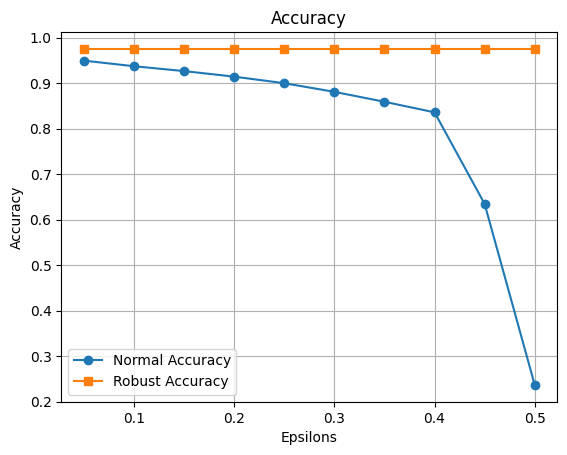

In [7]:
plt.plot(epsilons, normal_accuracy, marker='o', label='Normal Accuracy')
plt.plot(epsilons, robust_accuracy, marker='s', label='Robust Accuracy')

plt.xlabel('Epsilons')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.grid(True)
plt.show()

In [8]:
def compute_robustness(model, test_loader, epsilon):
    model.eval()
    total = 0
    robust = 0

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        lower_bound, upper_bound = bounds_calculation(model, data, epsilon)
        
        true_low = torch.tensor([lower_bound[i, target[i]] for i in range(len(target))])
        # print('true_low : ', true_low)
        
        mask = torch.ones_like(upper_bound, dtype=torch.bool)
        for i in range(len(target)):
            mask[i, target[i]] = False
        
        others_up = []

        for i in range(len(upper_bound)):
            other_class_bounds = upper_bound[i].clone()
            other_class_bounds[target[i]] = float('-inf')
            max_bound = torch.max(other_class_bounds)
            others_up.append(max_bound)
        
        others_up = torch.tensor(others_up)
        # print('others_up : ', others_up)
        
        is_robust = true_low > others_up
        
        robust += is_robust.sum().item()
        total += len(target)
        
        # print('is_robust :', is_robust)
    
    result = robust / total
    print(f'robust (epsilon = {epsilon}): {result}')
    
    return result

In [9]:
for epsilon in epsilons:
    compute_robustness(model, test_loader, epsilon)

robust (epsilon = 0.05): 0.0
robust (epsilon = 0.1): 0.0
robust (epsilon = 0.15): 0.0
robust (epsilon = 0.2): 0.0
robust (epsilon = 0.25): 0.0
robust (epsilon = 0.3): 0.0
robust (epsilon = 0.35): 0.0
robust (epsilon = 0.4): 0.0
robust (epsilon = 0.45): 0.0
robust (epsilon = 0.5): 0.0
